In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from itertools import product
    from fastcore.test import test_eq, test_fail, test_warns
    from dotenv import load_dotenv    

# Prediction intervals

In forecasting, we are often interested in a distribution of predictions rather than only a point prediction, because we want to have a notion of the uncertainty around the forecast.

To this end, we can create _prediction intervals_.

Prediction intervals have an intuitive interpretation, as they present a specific range of the forecast distribution. For instance, a 95% prediction interval means that 95 out of 100 times, we expect the future value to fall within the estimated range. Therefore, a wider interval indicates greater uncertainty about the forecast, while a narrower interval suggests higher confidence.

With TimeGPT, we can create a distribution of forecasts, and extract the prediction intervals for a required level.

TimeGPT uses [conformal prediction](https://en.wikipedia.org/wiki/Conformal_prediction) to produce the prediction intervals.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/11_uncertainty_quantification_with_prediction_intervals')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/11_uncertainty_quantification_with_prediction_intervals.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, set the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## 3. Forecast with prediction intervals
When using TimeGPT for time series forecasting, you can set the level (or levels) of prediction intervals according to your requirements. Here's how you could do it:

In [ ]:
timegpt_fcst_pred_int_df = nixtla_client.forecast(
    df=df, h=12, level=[80, 90, 99.7], 
    time_col='timestamp', target_col='value',
)
timegpt_fcst_pred_int_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,timestamp,TimeGPT,TimeGPT-lo-99.7,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-99.7
0,1961-01-01,437.837952,415.826484,423.783737,431.987091,443.688812,451.892166,459.849419
1,1961-02-01,426.062744,402.833553,407.694092,412.704956,439.420532,444.431396,449.291935
2,1961-03-01,463.116577,423.434092,430.316893,437.412564,488.820590,495.916261,502.799062
3,1961-04-01,478.244507,444.885193,446.776764,448.726837,507.762177,509.712250,511.603821
4,1961-05-01,505.646484,465.736694,471.976787,478.409872,532.883096,539.316182,545.556275


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

In [ ]:
#| hide
# test shorter horizon
if not IN_COLAB:
    level_short_horizon_df = nixtla_client.forecast(
        df=df, h=6, level=[80, 90, 99.7], 
        time_col='timestamp', target_col='value',
    )
    test_eq(
        level_short_horizon_df.shape,
        (6, 8)
    )

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
#| hide
if not IN_COLAB:
    test_level = [80, 90.5]
    cols_fcst_df = nixtla_client.forecast(
        df=df, h=12, level=test_level, 
        time_col='timestamp', target_col='value',
    ).columns
    assert all(f'TimeGPT-{pos}-{lv}' in cols_fcst_df for pos, lv in product(['lo', 'hi'], test_level) )

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


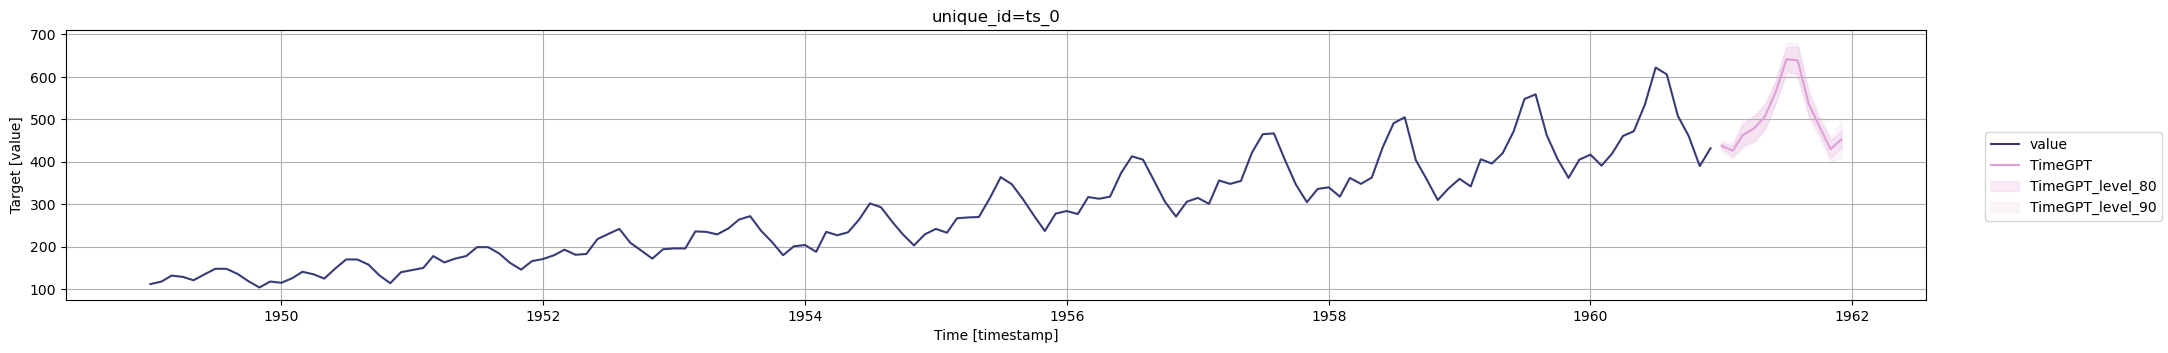

In [ ]:
nixtla_client.plot(
    df, timegpt_fcst_pred_int_df, 
    time_col='timestamp', target_col='value',
    level=[80, 90],
)

It's essential to note that the choice of prediction interval level depends on your specific use case. For high-stakes predictions, you might want a wider interval to account for more uncertainty. For less critical forecasts, a narrower interval might be acceptable.

#### Historical Forecast

You can also compute prediction intervals for historical forecasts adding the `add_history=True` parameter as follows:

In [ ]:
timegpt_fcst_pred_int_historical_df = nixtla_client.forecast(
    df=df, h=12, level=[80, 90], 
    time_col='timestamp', target_col='value',
    add_history=True,
)
timegpt_fcst_pred_int_historical_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


,timestamp,TimeGPT,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-hi-80,TimeGPT-hi-90
0,1951-01-01,135.483673,111.937767,105.262830,159.029579,165.704516
1,1951-02-01,144.442413,120.896508,114.221571,167.988319,174.663256
2,1951-03-01,157.191910,133.646004,126.971067,180.737815,187.412752
3,1951-04-01,148.769379,125.223473,118.548536,172.315284,178.990221
4,1951-05-01,140.472946,116.927041,110.252104,164.018852,170.693789


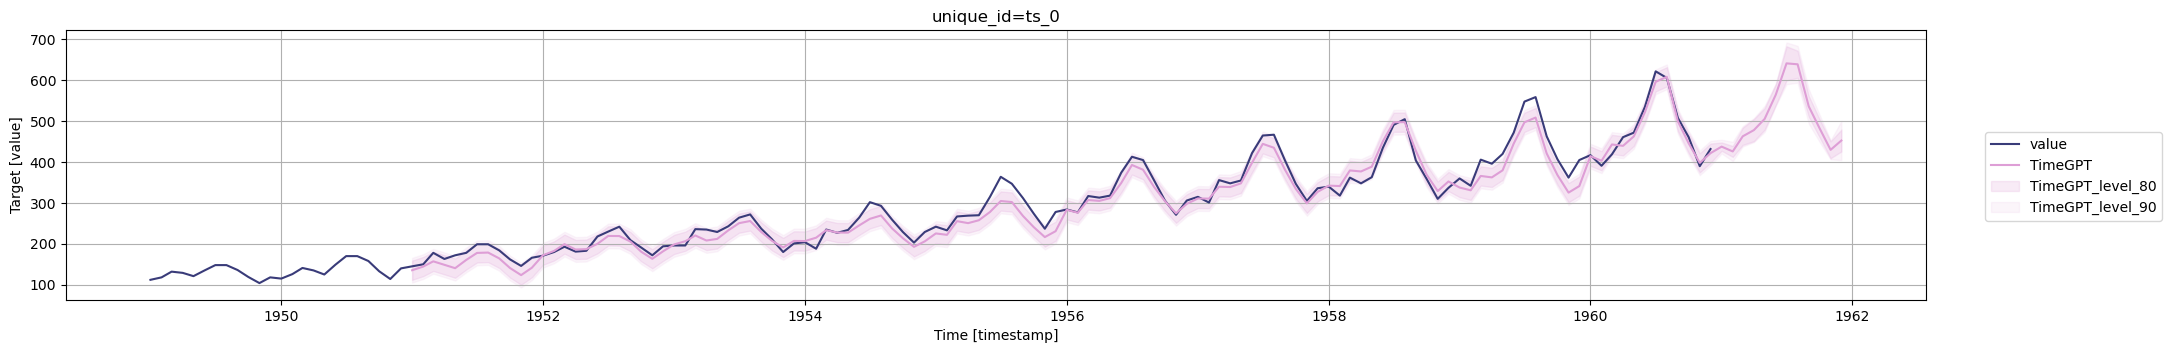

In [ ]:
nixtla_client.plot(
    df, timegpt_fcst_pred_int_historical_df, 
    time_col='timestamp', target_col='value',
    level=[80, 90],
)